In [1]:
# Uncomment line below to install exlib
# !pip install exlib

# Mass Maps
This is a notebook for MassMaps. 
The inputs are simulated weak lensing maps of the shape (batch_size, 1, 66, 66). 
The model predicts $\Omega_m$ and $\sigma_8$ from the weak lensing map.

In [2]:
import sys
sys.path.insert(0, "../../src")
import exlib
import torch
from datasets import load_dataset
from exlib.datasets.mass_maps import *

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/home/antonxue/lib/miniconda3/envs/exlib/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

In [3]:
# Load model
model = MassMapsConvnetForImageRegression.from_pretrained('BrachioLab/massmaps-conv')
model = model.to(device)

### Load Data

In [4]:
# Load data
train_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='train')
val_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='validation')
test_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='test')
train_dataset.set_format('torch', columns=['input', 'label'])
val_dataset.set_format('torch', columns=['input', 'label'])
test_dataset.set_format('torch', columns=['input', 'label'])

### Baselines for getting expert features

In [5]:
# Baselines
from exlib.features.vision.mass_maps import MassMapsOracle, MassMapsOne
from exlib.features.vision.watershed import WatershedGroups
from exlib.features.vision.quickshift import QuickshiftGroups
from exlib.features.vision.patch import PatchGroups

In [6]:
watershed_baseline = WatershedGroups(min_dist=10, compactness=0).to(device)

### Initialize the metric to evaluate expert features: FixScore

In [7]:
# Alignment
massmaps_align = MassMapsFixScore().to(device)

In [8]:
# Eval
batch_size = 5
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

import torch.nn.functional as F
from tqdm.auto import tqdm

model.eval()
mse_loss_all = 0
total = 0
fix_scores_all = []
fix_scores_all_non_reduced = []

with torch.no_grad():
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        X = batch['input'].to(device)
        y = batch['label'].to(device)
        out = model(X)
        # loss
        loss = F.mse_loss(out, y, reduction='none')
        mse_loss_all = mse_loss_all + loss.sum(0)
        total += X.shape[0]

        # baseline
        groups = watershed_baseline(X)

        # alignment
        alignment_scores = massmaps_align(groups, X)
        alignment_scores_all.extend(alignment_scores.flatten(1).cpu().numpy().tolist())
loss_avg = mse_loss_all / total

print(f'Omega_m loss {loss_avg[0].item():.4f}, sigma_8 loss {loss_avg[1].item():.4f}, avg loss {loss_avg.mean().item():.4f}')

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:12<00:00, 15.11it/s]

Omega_m loss 0.0050, sigma_8 loss 0.0112, avg loss 0.0081


In [9]:
# This is the non reduced score. The mean would be the same
print('non reduced score shape', fix_scores_non_reduced.shape)
total_score = torch.mean(fix_scores_non_reduced)
total_score

non reduced score shape torch.Size([60, 66, 66])


tensor(0.5567)

# Show FIXScores for some examples

In [11]:
import math
import matplotlib.pyplot as plt
from exlib.datasets.mass_maps import MassMapsFixScore

def show_example(groups, X, img_idx=0):
    massmaps_align = MassMapsFixScore().to(device)
    alignment_results = massmaps_align(groups, X, reduce='none')
    
    m = groups.shape[1]
    cols = 8
    rows = math.ceil(m / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
    axs = axs.ravel()

    image = X[img_idx]
    for idx in range(len(axs)):
        if idx < m:
            mask = groups[img_idx][idx]

            if mask.sum() > 0:
                axs[idx].imshow(image[0].cpu().numpy())
                axs[idx].contour(mask.cpu().numpy() > 0, 2, colors='red')
                axs[idx].contourf(mask.cpu().numpy() > 0, 2, hatches=['//', None, None],
                                cmap='gray', extend='neither', linestyles='--', alpha=0.01)
                p_void_ = alignment_results['p_void_']
                p_cluster_ = alignment_results['p_cluster_']
                purity = alignment_results['purity']
                # total_score = alignment_scores_void[0][idx].item() * massmaps_align.void_scale + alignment_scores_cluster[0][idx].item() * massmaps_align.cluster_scale
                axs[idx].set_title(f'void {p_void_[0][idx].item():.5f}\ncluster {p_cluster_[0][idx].item():.5f}\npurity {purity[0][idx].item():.5f}')
        axs[idx].axis('off')
    plt.show()

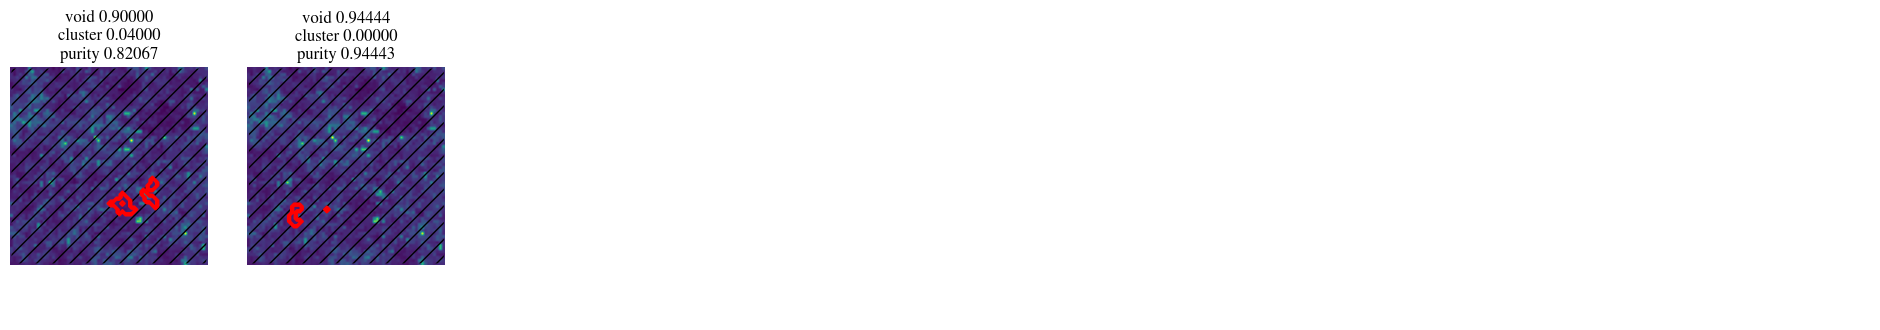

In [14]:
import torch
from exlib.datasets.mass_maps import MassMapsFixScore
watershed_baseline = WatershedGroups(min_dist=10, compactness=0).to(device).to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = watershed_baseline(X)
groups_show = torch.stack([groups[0:1,2], groups[0:1,6]], dim=1)
show_example(groups_show, X[0:1])

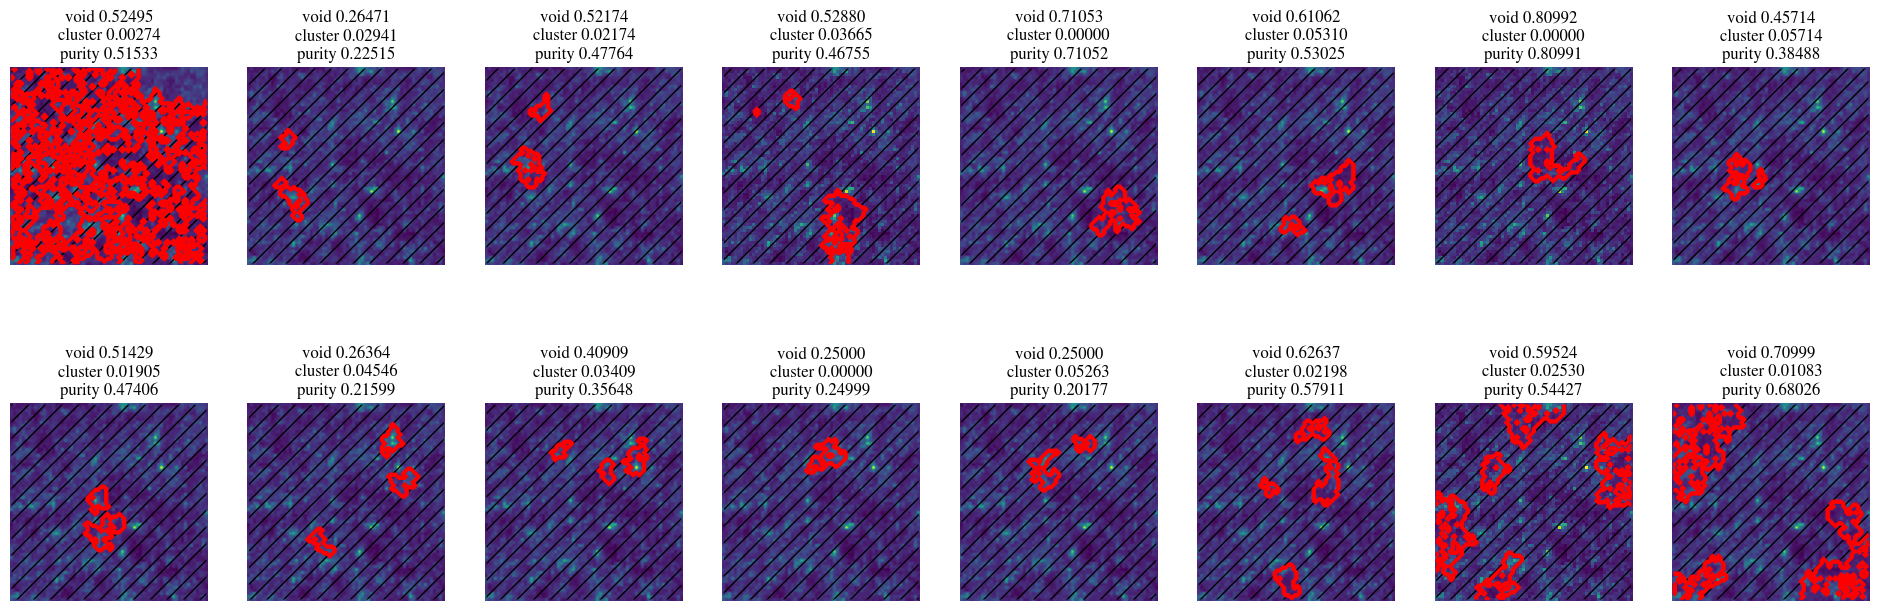

In [13]:
show_example(groups, X)

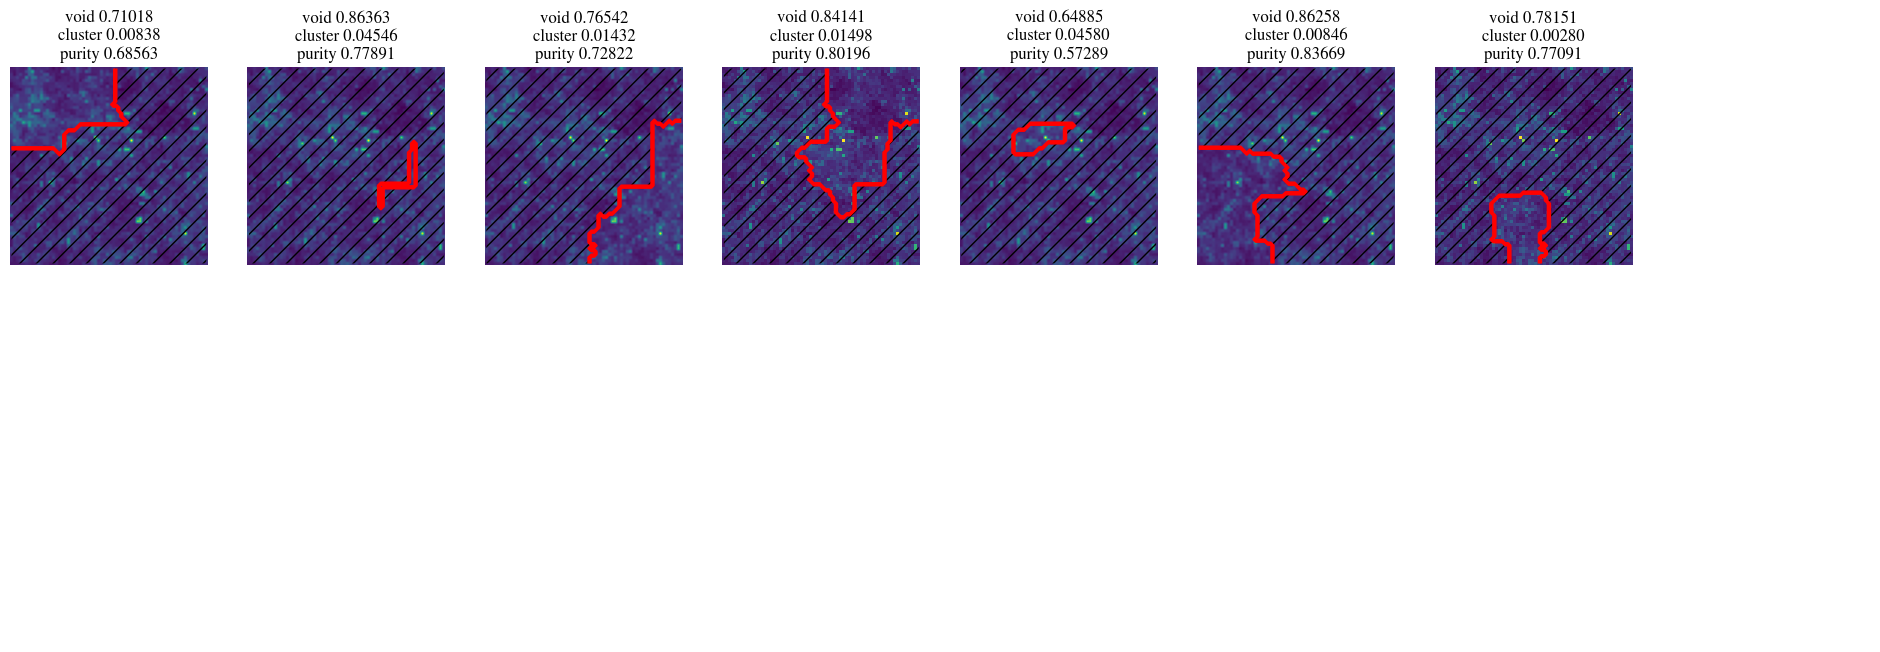

In [15]:
quickshift_baseline = QuickshiftGroups(
    kernel_size=5,
    max_dist=10,
    sigma=5).to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = quickshift_baseline(X)
show_example(groups, X)

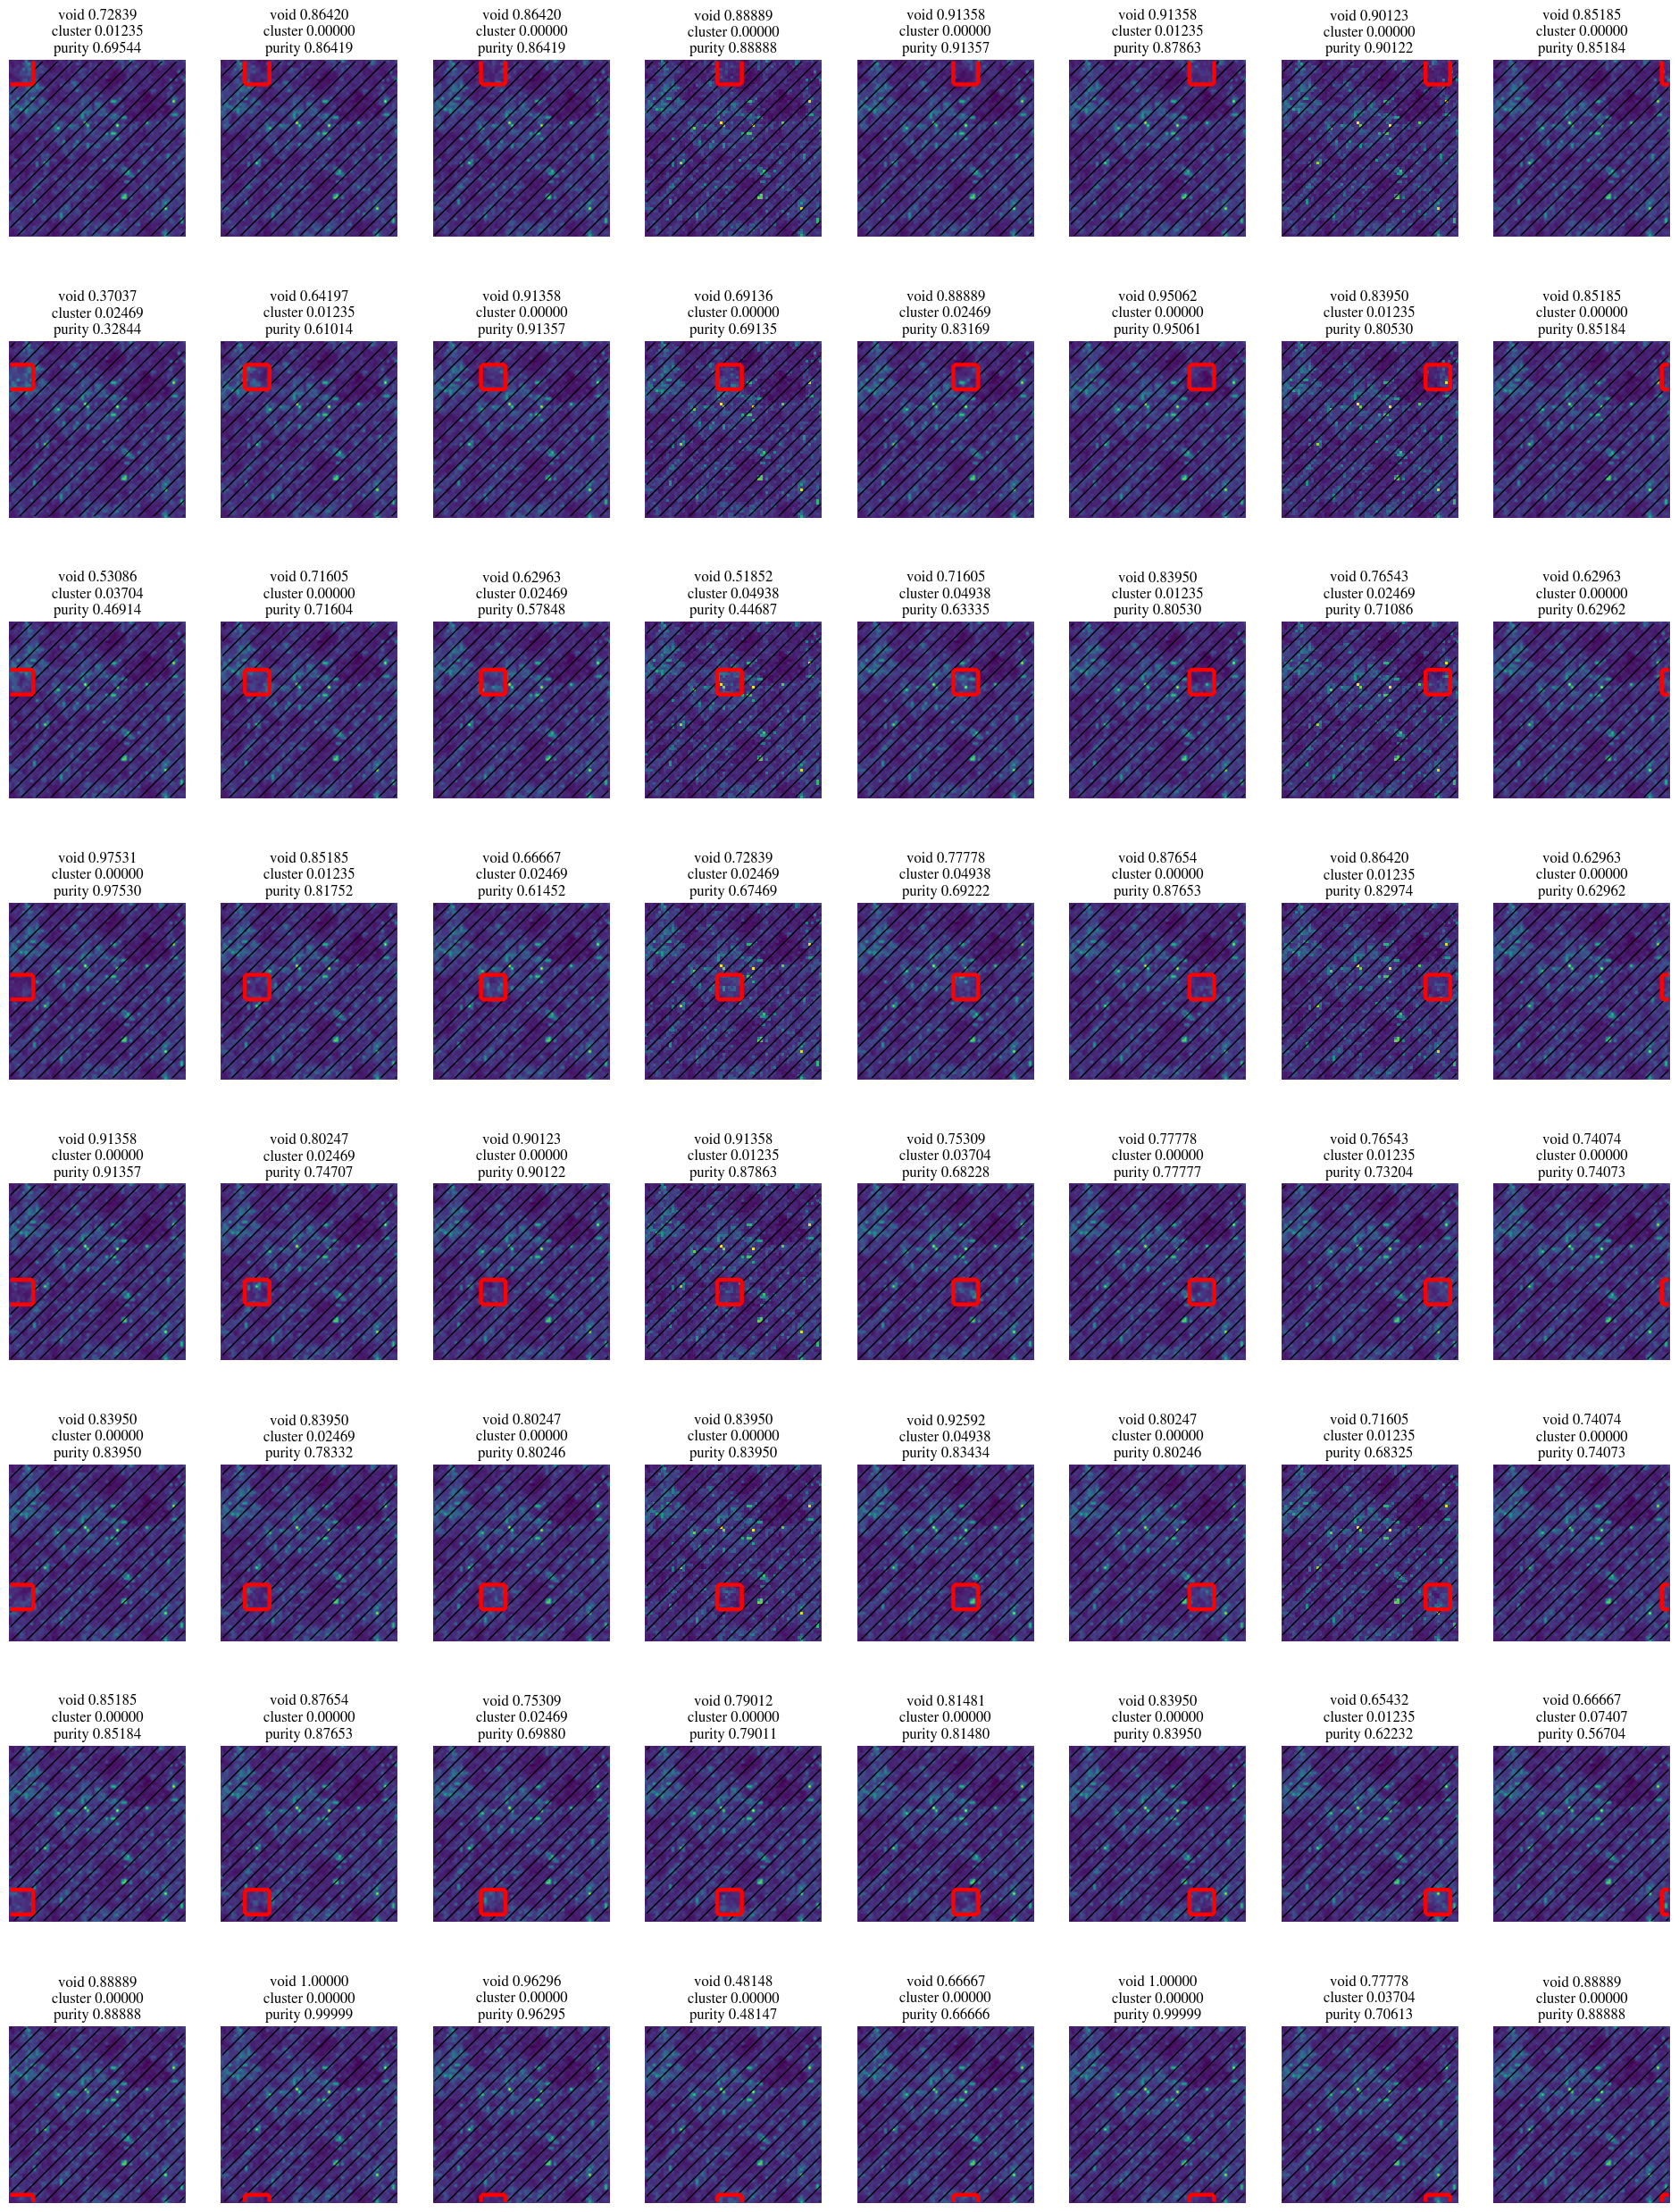

In [19]:
patch_baseline = PatchGroups(grid_size=(8, 8), mode='grid').to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = patch_baseline(X)
show_example(groups, X)

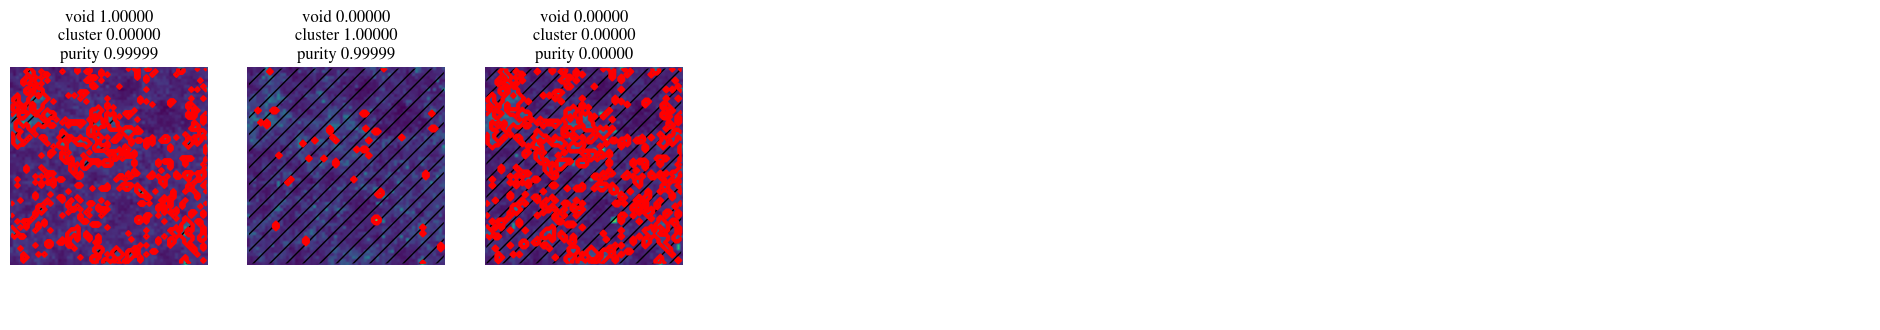

In [20]:
oracle_baseline = MassMapsOracle().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = oracle_baseline(X)
show_example(groups, X)

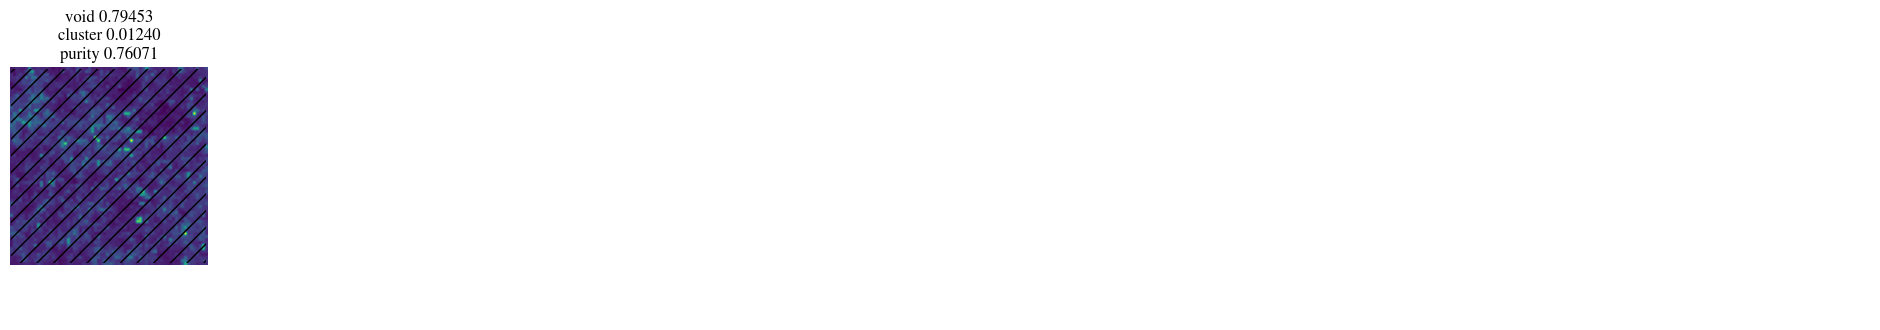

In [21]:
one_baseline = MassMapsOne().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = one_baseline(X)
show_example(groups, X)

# Compare baselines

In [22]:
mass_maps_fixscores = get_mass_maps_scores(subset=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:26<00:00,  2.38it/s]


Omega_m loss 0.0053, sigma_8 loss 0.0129, avg loss 0.0091


In [23]:
for name in mass_maps_fixscores:
    metric = torch.tensor(mass_maps_fixscores[name])
    mean_metric = metric.mean()
    print(f'{name}\t{mean_metric.item():.4f}')

identity	0.5427
random	0.5448
patch	0.5499
quickshift	0.5433
watershed	0.5523
sam	0.5474
ace	0.5457
craft	0.4004
archipelago	0.5489


In [24]:
from exlib.features.vision.watershed import WatershedGroups
watershed_baseline = WatershedGroups(min_dist=10, compactness=0)
mass_maps_fixscores_watershed = get_mass_maps_scores(['watershed'], subset=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 89.97it/s]

Omega_m loss 0.0053, sigma_8 loss 0.0129, avg loss 0.0091


In [25]:
torch.mean(mass_maps_fixscores_watershed['watershed'])

tensor(0.5523)